# CW1 Machine Learning Coursework
## Predicting Outcome with Regression Models
### Maram Talib | K-Number: K21184729



In [15]:
# Import required libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [16]:
# Set seed for reproducibility
np.random.seed(123)

## Data Loading and Exploration
### Understanding the dataset before model training



 Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   outcome  10000 non-null  float64
 1   carat    10000 non-null  float64
 2   cut      10000 non-null  object 
 3   color    10000 non-null  object 
 4   clarity  10000 non-null  object 
 5   depth    10000 non-null  float64
 6   table    10000 non-null  float64
 7   price    10000 non-null  int64  
 8   x        10000 non-null  float64
 9   y        10000 non-null  float64
 10  z        10000 non-null  float64
 11  a1       10000 non-null  float64
 12  a2       10000 non-null  float64
 13  a3       10000 non-null  float64
 14  a4       10000 non-null  float64
 15  a5       10000 non-null  float64
 16  b1       10000 non-null  float64
 17  b2       10000 non-null  float64
 18  b3       10000 non-null  float64
 19  b4       10000 non-null  float64
 20  b5       10000 non-null  float64
 

<Figure size 1200x800 with 0 Axes>

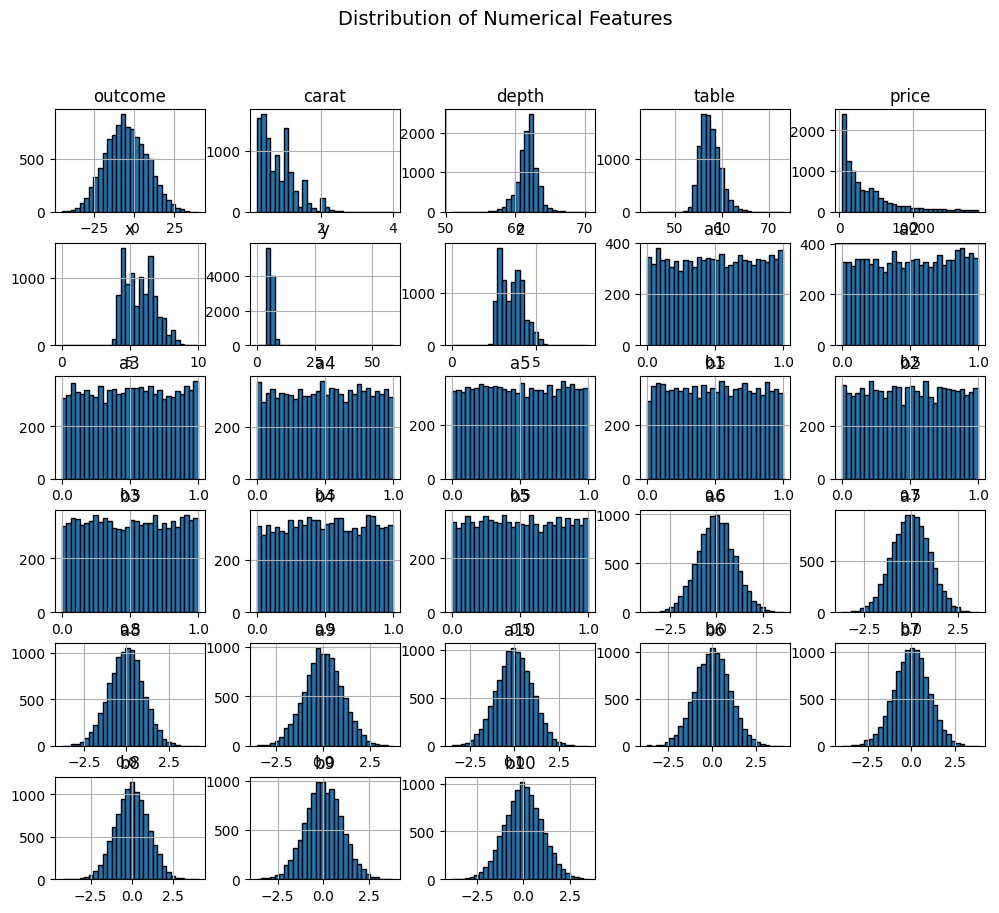

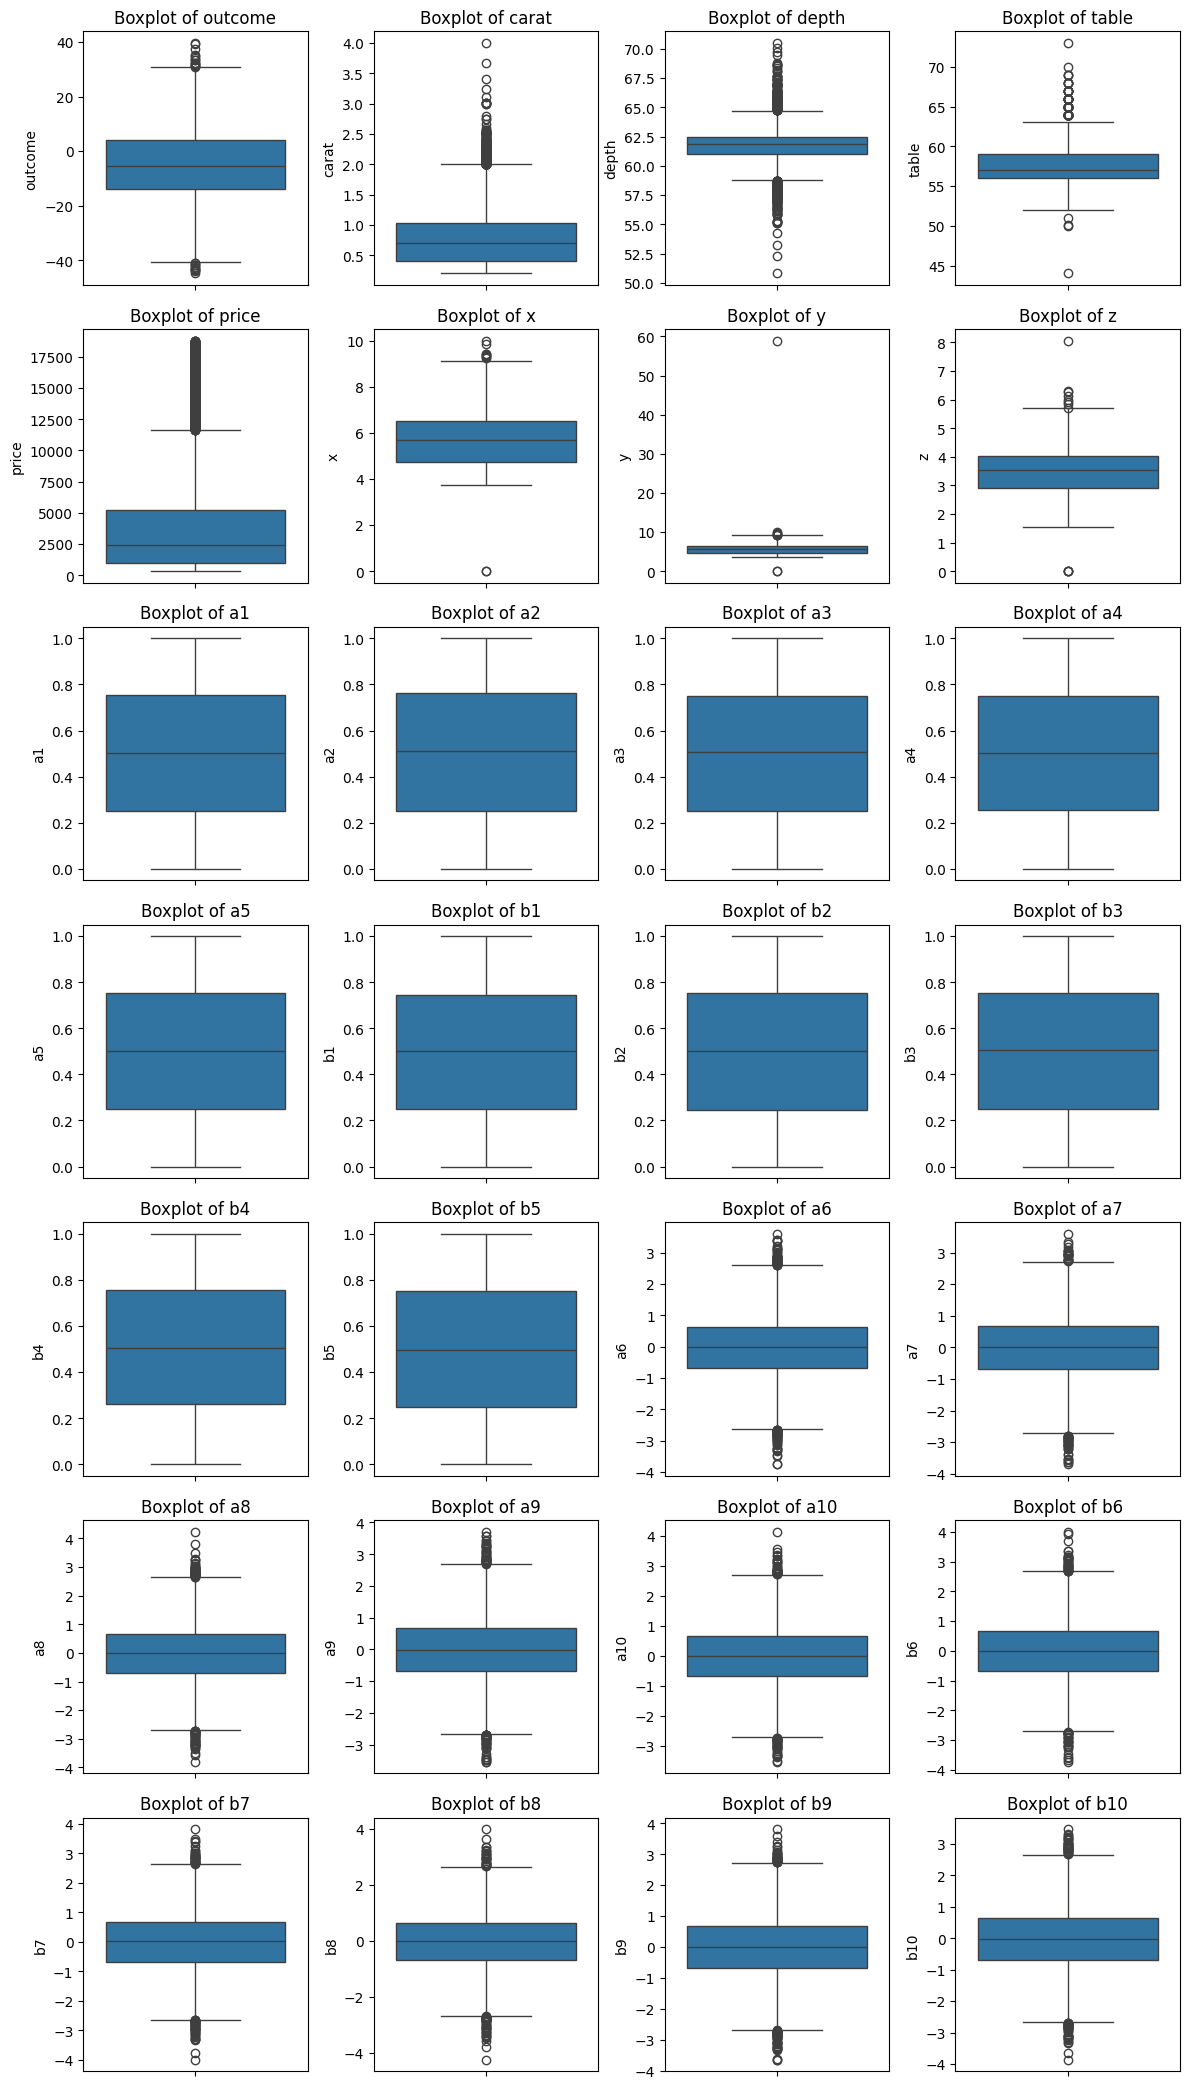

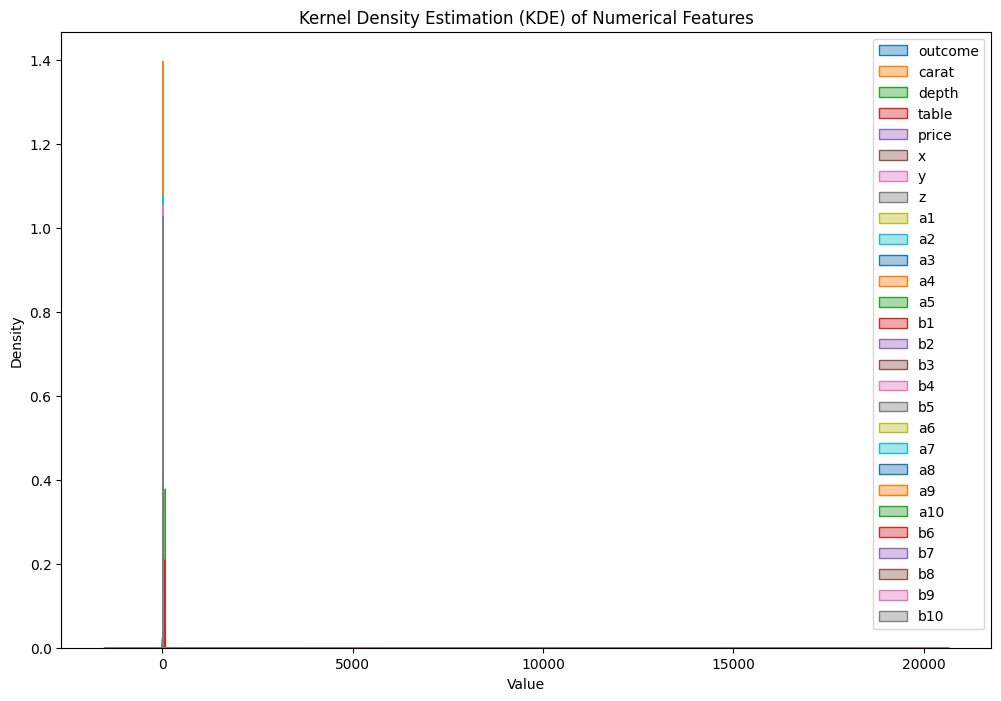

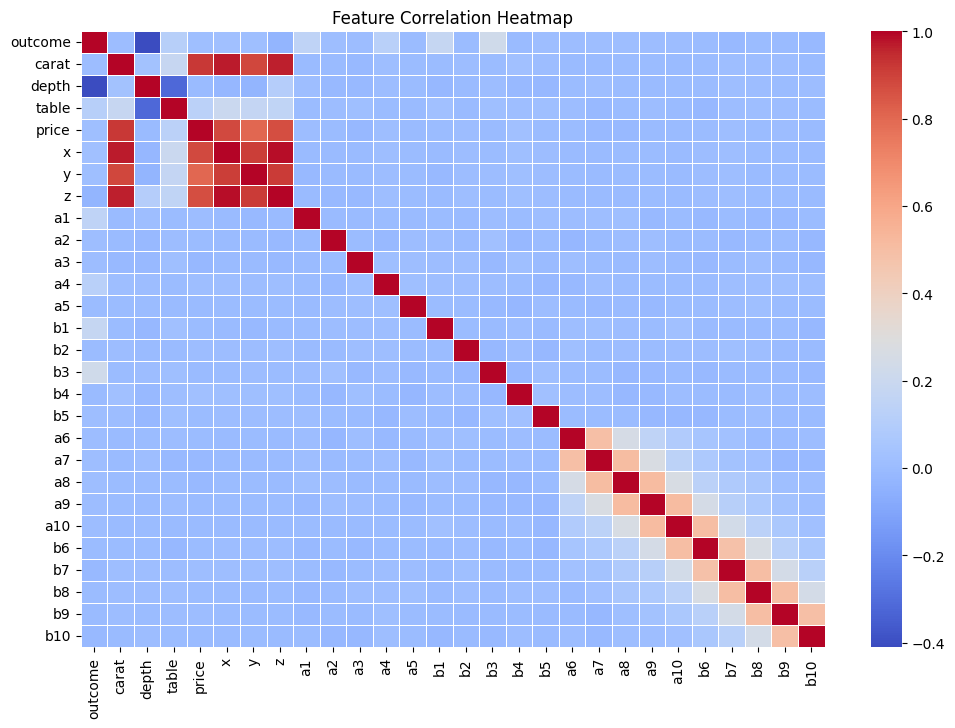

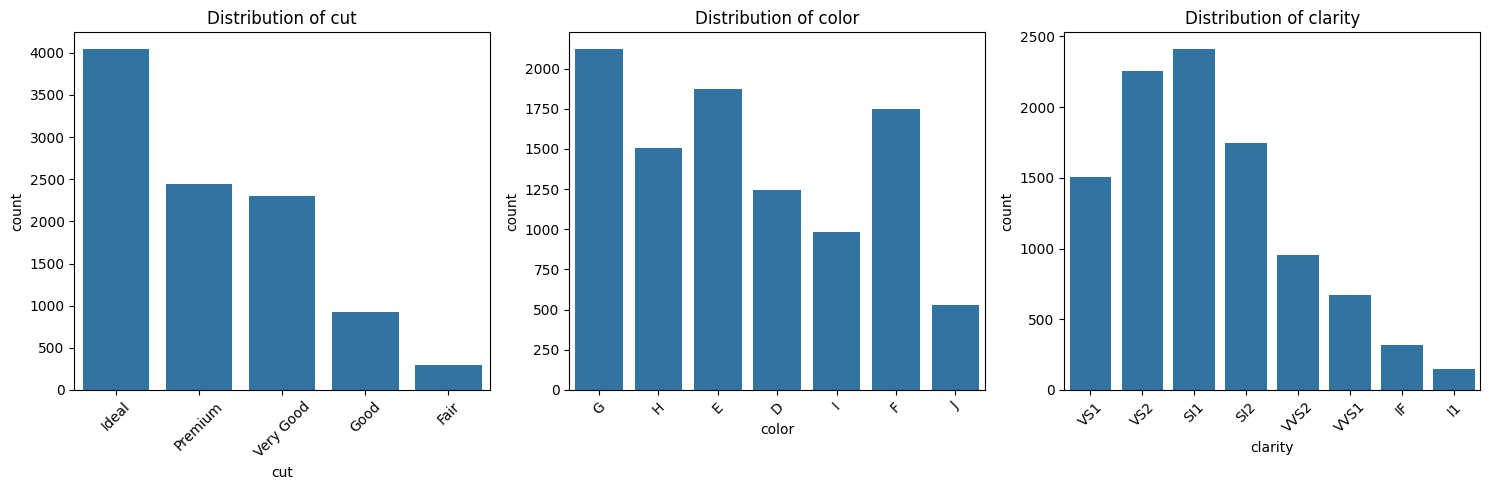

In [17]:
# Define paths relative to the notebook location
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Go up one level to MachineLearning/
data_dir = os.path.join(base_dir, "data")  # Path to data directory

train_path = os.path.join(data_dir, "CW1_train.csv")
test_path = os.path.join(data_dir, "CW1_test.csv")

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)  # No true outcomes

# Pre-processing Exploratory Data Analysis (EDA)**
print("\n Data Overview:")
print(df_train.info())  # Check data types & missing values
print("\n First 5 Rows of Training Data:")
print(df_train.head())

# Check missing values before handling
print("\n Missing Values (Before Handling):")
print(df_train.isnull().sum())

# Visualize distribution of numerical features
numerical_features = df_train.select_dtypes(include=[np.number]).columns.tolist()

plt.figure(figsize=(12, 8))
df_train[numerical_features].hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle("Distribution of Numerical Features", fontsize=14)
plt.show()

numerical_df = df_train.select_dtypes(include=[np.number])  # Select only numerical columns


# Box Plots: Detect Outliers (Fixed Grid Size)
num_features = len(numerical_features)
num_cols = 4  # Set number of columns in the grid
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)  # Calculate required rows

plt.figure(figsize=(12, num_rows * 3))  # Adjust figure size dynamically
for i, col in enumerate(numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)  # Dynamically set subplot grid size
    sns.boxplot(y=df_train[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel("")  # Remove redundant x-labels for cleaner plots

plt.tight_layout()
plt.show()


# KDE Plots: Examine Skewness of Each Numerical Feature
plt.figure(figsize=(12, 8))
for col in numerical_features:
    sns.kdeplot(df_train[col], label=col, fill=True, alpha=0.4)
plt.title("Kernel Density Estimation (KDE) of Numerical Features")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend(loc="upper right")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Categorical feature distribution
categorical_features = ['cut', 'color', 'clarity']
plt.figure(figsize=(15, 5))
for i, col in enumerate(categorical_features):
    plt.subplot(1, 3, i+1)
    sns.countplot(x=df_train[col])
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df_train[categorical_features] = df_train[categorical_features].astype('category')
df_test[categorical_features] = df_test[categorical_features].astype('category')

## Data Preprocessing
### Handling missing values, feature encoding, and transformations


In [18]:
# Handle Missing Values (Numerical Columns) -> Median Imputation
df_train.fillna(df_train.select_dtypes(include=[np.number]).median(), inplace=True)
df_test.fillna(df_test.select_dtypes(include=[np.number]).median(), inplace=True)

# Verify missing values after handling
print("\n Missing Values (After Handling):")
print(df_train.isnull().sum())

# One-hot encode categorical variables
df_train_encoded = pd.get_dummies(df_train, columns=categorical_features, drop_first=True)
df_test_encoded = pd.get_dummies(df_test, columns=categorical_features, drop_first=True)

# Ensure Test Set has the Same Features as Train Set
missing_cols = set(df_train_encoded.columns) - set(df_test_encoded.columns)
for col in missing_cols:
    df_test_encoded[col] = 0  # Add missing columns with default value
df_test_encoded = df_test_encoded[df_train_encoded.columns.drop('outcome', errors='ignore')]  # Align column order

# Define target and features
X = df_train_encoded.drop(columns=['outcome'])
y = df_train_encoded['outcome']
X_test = df_test_encoded  # Test set doesn't have outcome

# Perform an 80/20 train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=123)

# Feature Selection: Mutual Information Scores (Top 50)
mi_scores = mutual_info_regression(X_train, y_train)
mi_df = pd.DataFrame({'Feature': X_train.columns, 'MI Score': mi_scores})
selected_features = mi_df.sort_values(by='MI Score', ascending=False).head(50)['Feature'].tolist()

X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

# Polynomial Features (Top 7 and Degree 2)
top_features = selected_features[:7]

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_train = poly.fit_transform(X_train_selected[top_features])
poly_val = poly.transform(X_val_selected[top_features])
poly_test = poly.transform(X_test_selected[top_features])

# Assign Feature Names
poly_feature_names = poly.get_feature_names_out(top_features)

df_poly_train = pd.DataFrame(poly_train, columns=poly_feature_names, index=X_train_selected.index)
df_poly_val = pd.DataFrame(poly_val, columns=poly_feature_names, index=X_val_selected.index)
df_poly_test = pd.DataFrame(poly_test, columns=poly_feature_names, index=X_test_selected.index)

# Merge Polynomial Features
X_train_selected = pd.concat([X_train_selected, df_poly_train], axis=1)
X_val_selected = pd.concat([X_val_selected, df_poly_val], axis=1)
X_test_selected = pd.concat([X_test_selected, df_poly_test], axis=1)

# Remove Duplicate Columns
X_train_selected = X_train_selected.loc[:, ~X_train_selected.columns.duplicated()]
X_val_selected = X_val_selected.loc[:, ~X_val_selected.columns.duplicated()]
X_test_selected = X_test_selected.loc[:, ~X_test_selected.columns.duplicated()]

# Apply **Standard Scaling**
scaler = StandardScaler()
X_train_selected = pd.DataFrame(scaler.fit_transform(X_train_selected), columns=X_train_selected.columns)
X_val_selected = pd.DataFrame(scaler.transform(X_val_selected), columns=X_val_selected.columns)
X_test_selected = pd.DataFrame(scaler.transform(X_test_selected), columns=X_test_selected.columns)


 Missing Values (After Handling):
outcome    0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
a1         0
a2         0
a3         0
a4         0
a5         0
b1         0
b2         0
b3         0
b4         0
b5         0
a6         0
a7         0
a8         0
a9         0
a10        0
b6         0
b7         0
b8         0
b9         0
b10        0
dtype: int64


## Model Training & Hyperparameter Tuning
### Optimizing CatBoost, XGBoost, and LGBM


In [19]:
# Define the best hyperparameters (pre-tuned)
best_catboost = CatBoostRegressor(
    iterations=2100,
    learning_rate=0.04,
    depth=6,
    border_count=128,
    bootstrap_type='Bayesian',
    bagging_temperature=3.3373364364285694,
    task_type="CPU",
    random_seed=123,
    logging_level="Silent"
)
# Apply the **Exact Optimized Weights** for Blending
w_cat, w_xgb, w_lgbm = 0.1282, 0.6478, 0.2240

# Train Final Model
best_catboost.fit(X_train_selected, y_train)

# Train Additional Models for Stacking
xgb_model = XGBRegressor(n_estimators=600, learning_rate=0.05, max_depth=2, random_state=123)
lgbm_model = LGBMRegressor(n_estimators=1800, learning_rate=0.05, max_depth=2, random_state=123)

xgb_model.fit(X_train_selected, y_train)
lgbm_model.fit(X_train_selected, y_train)


# Delete catboost_info directory after training
shutil.rmtree("catboost_info", ignore_errors=True)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11885
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 65
[LightGBM] [Info] Start training from score -4.973247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

## Model Evaluation
### Assessing model performance using R² and residual analysis


In [20]:
# Compute R² Score on Training Set
y_train_pred = (w_cat * best_catboost.predict(X_train_selected)) + \
               (w_xgb * xgb_model.predict(X_train_selected)) + \
               (w_lgbm * lgbm_model.predict(X_train_selected))

train_r2 = r2_score(y_train, y_train_pred)
print(f"\n Training R² Score: {train_r2:.4f}")

# Compute R² Score on Validation Set
y_val_pred = (w_cat * best_catboost.predict(X_val_selected)) + \
             (w_xgb * xgb_model.predict(X_val_selected)) + \
             (w_lgbm * lgbm_model.predict(X_val_selected))

val_r2 = r2_score(y_val, y_val_pred)
print(f" Validation R² Score: {val_r2:.4f}")


 Training R² Score: 0.5882
 Validation R² Score: 0.4760


## Generating Final Predictions & Submission
### Save output for evaluation


In [21]:
# Make Final Predictions on Test Set using Weighted Blending
y_pred_final = (w_cat * best_catboost.predict(X_test_selected)) + \
               (w_xgb * xgb_model.predict(X_test_selected)) + \
               (w_lgbm * lgbm_model.predict(X_test_selected))
# Ensure the data directory exists (useful for portability)
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
os.makedirs(data_dir, exist_ok=True)

# Define the path to save the submission file in the 'data' directory
submission_path = os.path.join(data_dir, "CW1_submission_K21184729.csv")

# Save Predictions
submission = pd.DataFrame({'yhat': y_pred_final})
submission.to_csv(submission_path, index=False)

print(f"\n Predictions saved successfully at: {submission_path}")



 Predictions saved successfully at: d:\MachineLearningCW1\data\CW1_submission_K21184729.csv


 ## Model Performance Evaluation & Residual Analysis
### Assessing prediction accuracy and identifying potential biases.

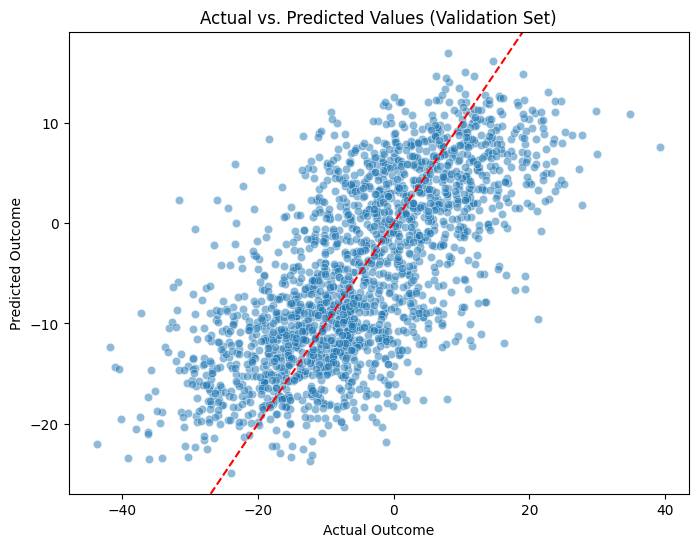

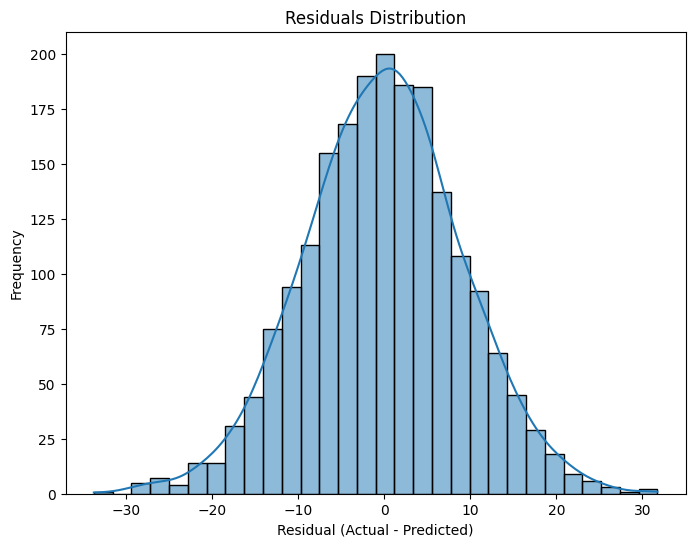

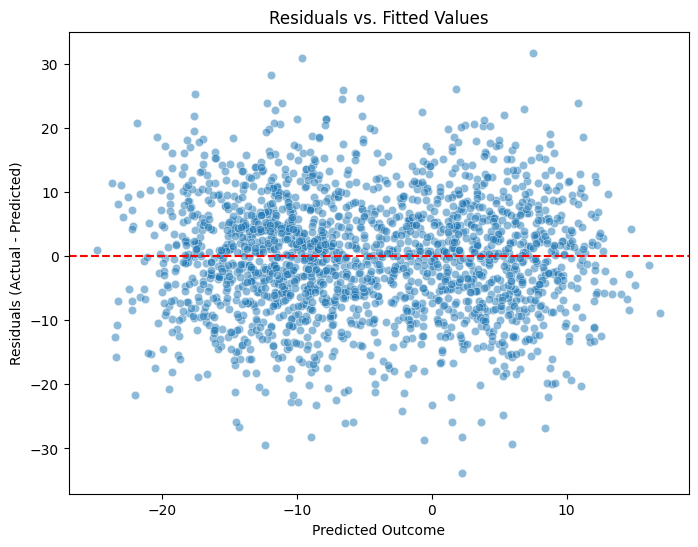

In [22]:
# Scatter Plot: Actual vs. Predicted (Validation Set)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_val_pred, alpha=0.5)
plt.xlabel("Actual Outcome")
plt.ylabel("Predicted Outcome")
plt.title("Actual vs. Predicted Values (Validation Set)")
plt.axline([0, 0], slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.show()

# Residuals Calculation
residuals = y_val.values - y_val_pred

# Residuals Plot (Errors: Actual - Predicted)
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()

# Residuals vs. Fitted Values Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Outcome")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Fitted Values")
plt.show()


 Summary Statistics for Actual Values:
count    8000.000000
mean       -4.973247
std        12.742872
min       -44.879471
25%       -14.103135
50%        -5.360602
75%         3.983246
max        39.675966
Name: outcome, dtype: float64

 Summary Statistics for Predicted Values:
count    8000.000000
mean       -4.973247
std         8.851245
min       -28.038918
25%       -12.093826
50%        -5.784201
75%         2.428708
max        19.302279
dtype: float64
      Actual  Predicted
0  11.075700   7.993432
1  -3.300513   3.191492
2   8.034997   4.401042
3  -0.903989  -7.137693
4  -0.903082  -9.546501
5  -4.584038 -14.216167
6  -5.419748  -9.550043
7 -10.163155  -8.894917
8  11.138014   5.145729
9  -6.934083   1.741062


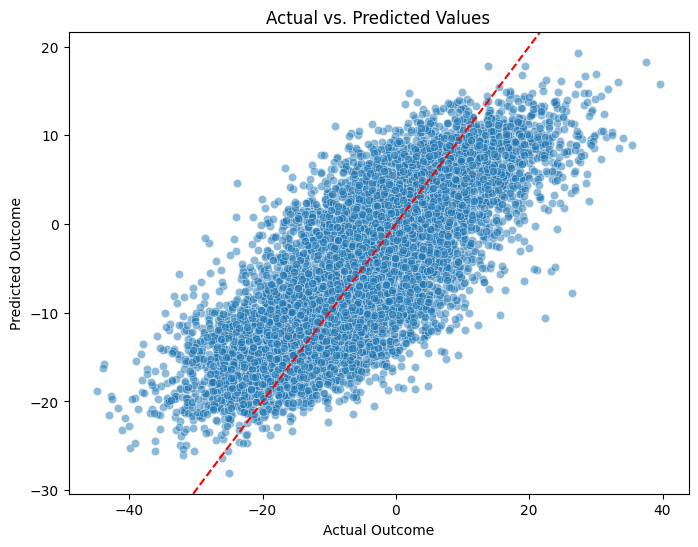

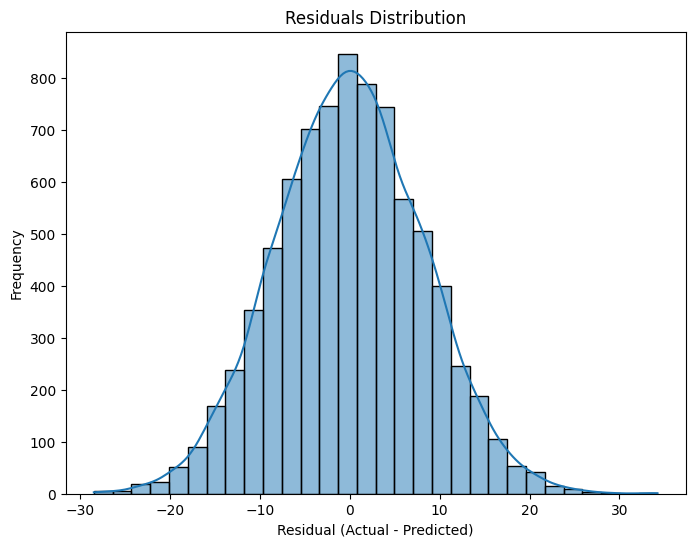

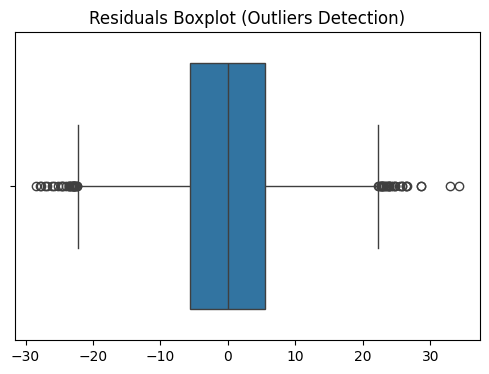

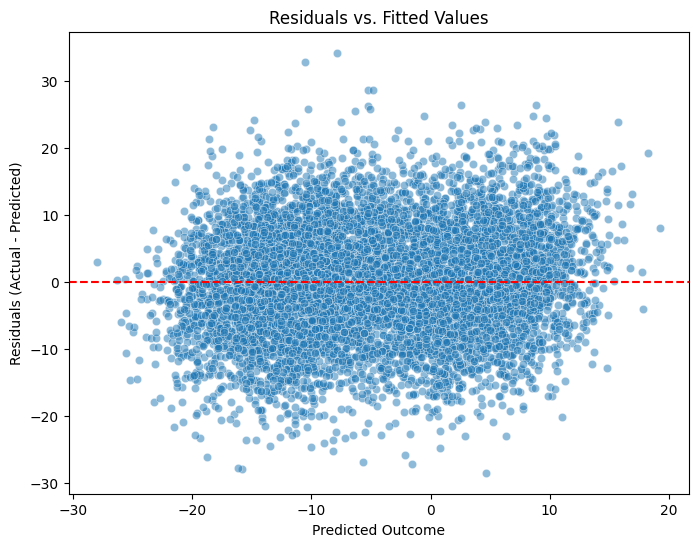

In [23]:
# Load Ground Truth (Ensure Matching Data)
# Print Summary Statistics
print("\n Summary Statistics for Actual Values:")
print(y_train.describe())

print("\n Summary Statistics for Predicted Values:")
print(pd.Series(y_train_pred).describe())

# Compare Actual vs. Predicted in DataFrame
comparison_df = pd.DataFrame({'Actual': y_train.values, 'Predicted': y_train_pred})  # Ensure matching dimensions
print(comparison_df.head(10))  # Show first 10 comparisons

# Scatter Plot: Actual vs. Predicted (Training Set)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.5)
plt.xlabel("Actual Outcome")
plt.ylabel("Predicted Outcome")
plt.title("Actual vs. Predicted Values")
plt.axline([0, 0], slope=1, color="red", linestyle="--")  # Perfect prediction line
plt.show()

# Residuals Calculation
residuals = y_train.values - y_train_pred  # Ensure proper subtraction

# Residuals Plot (Errors: Actual - Predicted)
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()

# Box Plot for Residuals (Outlier Check)
plt.figure(figsize=(6, 4))
sns.boxplot(x=residuals)
plt.title("Residuals Boxplot (Outliers Detection)")
plt.show()

# Residuals vs. Fitted Values Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_train_pred, y=residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Outcome")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Fitted Values")
plt.show()
